In [314]:
!pip list

Package                   Version
------------------------- ---------------
anyio                     4.3.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
attrs                     23.2.0
beautifulsoup4            4.12.3
bleach                    6.1.0
cached-property           1.5.2
certifi                   2024.2.2
cffi                      1.16.0
click                     8.1.7
colorama                  0.4.6
comm                      0.2.1
contourpy                 1.2.0
cycler                    0.12.1
debugpy                   1.8.1
decorator                 5.1.1
defusedxml                0.7.1
entrypoints               0.4
exceptiongroup            1.2.0
executing                 2.0.1
fastjsonschema            2.19.1
fonttools                 4.49.0
fqdn                      1.5.1
idna                      3.6
importlib-metadata        7.0.1
importlib-resources       6.1.1
ipykernel            

In [322]:
import pandas as pd
import seaborn as sns
import random
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from sklearn.decomposition import PCA, TruncatedSVD, FactorAnalysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [316]:
# Import dataset
df = pd.read_csv('Leukemia_GSE9476.csv')
df.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Hs28SrRNA-5_at,AFFX-r2-Hs28SrRNA-M_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,1,Bone_Marrow_CD34,7.745245,7.811210,6.477916,8.841506,4.546941,7.957714,5.344999,4.673364,...,5.058849,6.810004,12.800060,12.718612,5.391512,4.666166,3.974759,3.656693,4.160622,4.139249
1,12,Bone_Marrow_CD34,8.087252,7.240673,8.584648,8.983571,4.548934,8.011652,5.579647,4.828184,...,4.436153,6.751471,12.472706,12.333593,5.379738,4.656786,4.188348,3.792535,4.204414,4.122700
2,13,Bone_Marrow_CD34,7.792056,7.549368,11.053504,8.909703,4.549328,8.237099,5.406489,4.615572,...,4.392061,6.086295,12.637384,12.499038,5.316604,4.600566,3.845561,3.635715,4.174199,4.067152
3,14,Bone_Marrow_CD34,7.767265,7.094460,11.816433,8.994654,4.697018,8.283412,5.582195,4.903684,...,4.633334,6.375991,12.903630,12.871454,5.179951,4.641952,3.991634,3.704587,4.149938,3.910150
4,15,Bone_Marrow_CD34,8.010117,7.405281,6.656049,9.050682,4.514986,8.377046,5.493713,4.860754,...,5.305192,6.700453,12.949352,12.782515,5.341689,4.560315,3.887020,3.629853,4.127513,4.004316


## Data Cleaning

CuMiDa preforms extensive preprocessing on the data, including quality and normalisation checks.

In [317]:
df.type = df.type.map({'AML':'AML', 'Bone_Marrow': 'Bone Marrow', 'Bone_Marrow_CD34': 'Bone Marrow CD34+', 'PB':'PB', 'PBSC_CD34': 'PBSC CD34+'})

In [318]:
df.isnull().sum().sum()

0

## Data Exploration

In [320]:
palette = {'AML': 'r',
 'PB': 'blue',
 'PBSC CD34+': 'darkblue',
 'Bone Marrow': 'seagreen',
 'Bone Marrow CD34+': 'mediumseagreen'}

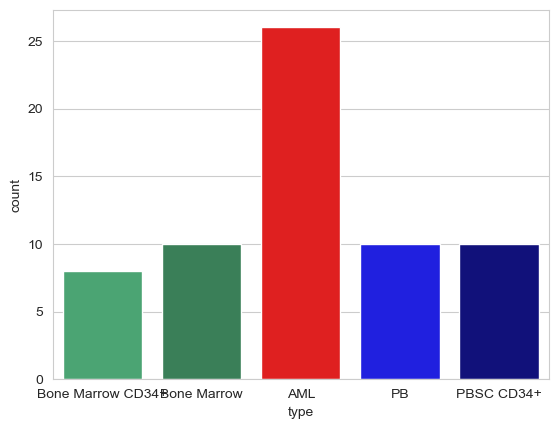

In [321]:
# class imbalance towards AML for multi-classifiaction
sns.countplot(data=df, x='type', palette=palette, hue='type')
plt.show()

In [ ]:
# Separate features and target
y = df['type']
X = df.drop(['type', 'samples'], axis=1) 

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [283]:
# function taken from matplotlib documentation (https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html)

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

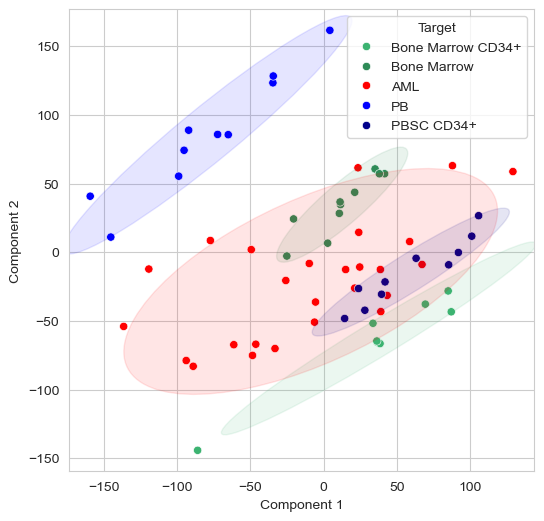

In [323]:
# Apply PCA 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convert the result into a DataFrame for easier plotting
pca_df = pd.DataFrame(data = X_pca, columns = ['Component 1', 'Component 2'])
pca_df['Target'] = y

# Plot the PCA
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.scatterplot(x='Component 1', y='Component 2', hue='Target', data=pca_df, palette=palette)
# Plot the 95% confidence interval
for cls in pca_df['Target'].unique(): 
    df_ = pca_df[pca_df['Target'] == cls]
    confidence_ellipse(df_['Component 1'], df_['Component 2'], ax, edgecolor=palette[cls], alpha=0.1, facecolor=palette[cls], n_std=1.96)  # 95% confidence interval
plt.show()

## Model Training and Selection

attmept to replicate literature results from CuMiDa

In [324]:
# train test split (stratified by default)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=12)
print(len(X_train), len(X_test))

51 13


C:\Users\wallace5\AppData\Local\Temp\ipykernel_18780\3617349803.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['AML', 'PB', 'PBSC\nCD34+', 'Bone Marrow', 'Bone Marrow\nCD34+'])


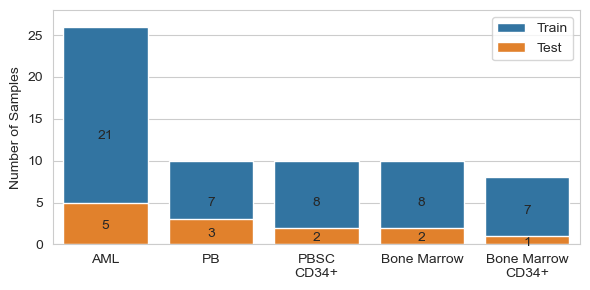

In [248]:
# Train/Test class distribution

train_counts = y_train.value_counts().sort_values()
test_counts = y_test.value_counts().sort_values()

combined_counts = pd.DataFrame({'Train': train_counts+test_counts, 'Test': test_counts}).sort_values('Test', ascending=False).reset_index()
combined_counts_melted = pd.melt(combined_counts, id_vars='index', var_name='Type', value_name='Count')

f, ax = plt.subplots(figsize=(6, 3))
barplot = sns.barplot(x='index', y='Count', hue='Type', data=combined_counts_melted, dodge=False)

plt.xlabel('')
plt.ylabel('Number of Samples')
plt.gca().set_xticklabels(['AML', 'PB', 'PBSC\nCD34+', 'Bone Marrow', 'Bone Marrow\nCD34+'])
plt.legend()
plt.tight_layout()
plt.ylim(0,28)

# Adding annotations to test bars
for p in barplot.patches[5:-2]:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height()/2-1, '%d' % int(p.get_height()), 
            fontsize=10, ha='center', va='bottom')

# Adding annotations to train bars
lst = [21, 7, 8, 8, 7]
for idx, p in enumerate(barplot.patches[:5]):
    ax.text(p.get_x() + p.get_width() / 2., p.get_height()/2, lst[idx], 
            fontsize=10, ha='center', va='center')

plt.show()

In [19]:
# Define classifiers config
classifiers = {
    "SVM": {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10, 100], 
            'kernel': ['linear']
        }
    },
    "DT": {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [None, 20, 30, 40],
            'min_samples_split': [2, 5, 10]
        }
    },
    "RF": {
        'model': RandomForestClassifier(),
        'params': {    
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [None, 10, 20, 30]
        }
    },
    "NB": {
        'model': GaussianNB(),
        'params': {}
    },
    "MLP ": {
        'model': MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000),
        'params': {
            'activation': ['tanh', 'relu'],
            'max_iter': [500, 1000, 5000]
        }
    },
    "KNN": {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }
    }
}

In [20]:
# Apply leave one out cross-validation and collect accuracies
results = []
for name, clf in classifiers.items():
    cv_scores = cross_val_score(clf['model'], X_train, y_train, cv=LeaveOneOut(), scoring='accuracy')
    results.append({"Classifier": name, "Baseline Acc.": round(cv_scores.mean(), 2), "Baseline. std": round(cv_scores.std(), 2)})
    print(name, round(cv_scores.mean(), 2))

SVM 0.94
DT 0.73
RF 0.96
NB 0.88


C:\Users\wallace5\AppData\Local\miniforge3\envs\exeter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP  0.86
KNN 0.88


In [21]:
# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results)
results_df = pd.concat([results_df, pd.DataFrame({'CuMiDa':[0.98, 0.89, 0.98, 0.89, 0.94, 0.89]})], axis=1)
results_df

,Classifier,Baseline Acc.,Baseline. std,CuMiDa
0,SVM,0.94,0.24,0.98
1,DT,0.73,0.45,0.89
2,RF,0.96,0.19,0.98
3,NB,0.88,0.32,0.89
4,MLP,0.86,0.34,0.94
5,KNN,0.88,0.32,0.89


SVM and RF have the highest accuracies across both the literature and the cross-validation results, so we will continue with these two models. This also fits nicely with other literature that suggests that these are the best models.

## Hyperparameter Sweep

choice of cross validation: LOO vs K-fold (talk about variance vs bias). LOO is low bias, high variance, K-fold strikes a balance between the two, however with K=3, the variance is still high.

In [22]:
# sweep hyperparameters of each classifier using GridSearchCV. Save the best model and parameters for each.
for name, clf in classifiers.items():
    grid_search = GridSearchCV(clf['model'], clf['params'], cv=LeaveOneOut(), scoring='accuracy')
    grid_search.fit(X_train, y_train)
    clf['best_model'] = grid_search.best_estimator_ 
    clf['best_params'] = grid_search.best_params_
    clf['best_score'] = grid_search.best_score_
    print(f"{name}:\n"
          f"Best parameters: {grid_search.best_params_}\n"
          f"Best score: {grid_search.best_score_:.3f}\n\n")

SVM:
Best parameters: {'C': 0.1, 'kernel': 'linear'}
Best score: 0.980

DT:
Best parameters: {'max_depth': None, 'min_samples_split': 10}
Best score: 0.804

RF:
Best parameters: {'max_depth': 10, 'n_estimators': 200}
Best score: 1.000

NB:
Best parameters: {}
Best score: 0.882


C:\Users\wallace5\AppData\Local\miniforge3\envs\exeter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\wallace5\AppData\Local\miniforge3\envs\exeter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\wallace5\AppData\Local\miniforge3\envs\exeter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\wallace5\AppData\Local\miniforge3\envs\exeter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti

MLP :
Best parameters: {'activation': 'tanh', 'max_iter': 500}
Best score: 0.902

KNN:
Best parameters: {'n_neighbors': 5, 'weights': 'uniform'}
Best score: 0.882


In [23]:
results_df_ = pd.concat([results_df, 
                         pd.DataFrame({'Tuned Acc.':[round(clf['best_score'], 2) for clf in classifiers.values()]})], axis=1)
results_df_

,Classifier,Baseline Acc.,Baseline. std,CuMiDa,Tuned Acc.
0,SVM,0.94,0.24,0.98,0.98
1,DT,0.73,0.45,0.89,0.80
2,RF,0.96,0.19,0.98,1.00
3,NB,0.88,0.32,0.89,0.88
4,MLP,0.86,0.34,0.94,0.90
5,KNN,0.88,0.32,0.89,0.88


## Test Set Scores

In [24]:
results_df_ = pd.concat([results_df_, 
                         pd.DataFrame({'Test Acc.':[round(clf['best_model'].score(X_test, y_test), 2) for clf in classifiers.values()]})], axis=1)
results_df_

,Classifier,Baseline Acc.,Baseline. std,CuMiDa,Tuned Acc.,Test Acc.
0,SVM,0.94,0.24,0.98,0.98,1.00
1,DT,0.73,0.45,0.89,0.80,0.85
2,RF,0.96,0.19,0.98,1.00,1.00
3,NB,0.88,0.32,0.89,0.88,0.85
4,MLP,0.86,0.34,0.94,0.90,0.77
5,KNN,0.88,0.32,0.89,0.88,0.85


In [27]:
print(classifiers['SVM']['best_params'])
print(classifiers['RF']['best_params'])

{'C': 0.1, 'kernel': 'linear'}
{'max_depth': 10, 'n_estimators': 200}


Use SVM going forward as it has the highest test accuracy, and test acc. > train acc. (less likely to be overfitting).

## Feature Extraction Methods

In [165]:
# Feature extraction configuration
f_extraction = {
    'PCA': {'method':PCA},
    'FA': {'method':FactorAnalysis},
    'SVD': {'method':TruncatedSVD}
}

In [302]:
n_feat = 7
n_features = list(range(1, n_feat+1))
df_feats = pd.DataFrame({'n_features': n_features})

In [303]:
# Calculate test acc. for increasing number of features for each feature extraction method. Stop when acc. = 1
for name, method in f_extraction.items():
    accs = []
    for i in range(1, n_feat):
        # Apply the feature extraction method with i components
        fe = method['method'](n_components=i)
        X_train_fe = fe.fit_transform(X_train)
        X_test_fe = fe.transform(X_test)
        
        # Train SVM
        svc = SVC(**classifiers['SVM']['best_params'])
        svc.fit(X_train_fe, y_train)
        acc = svc.score(X_test_fe, y_test)
        accs.append(acc)
        
        # if acc = 1, save the number of features, feature importance's, the model and stop
        if acc == 1:
            f_extraction[name]['n_features'] = i
            f_extraction[name]['model'] = fe
            
            # most important features
            features = list(zip(X.columns, np.abs(fe.components_).mean(axis=0)))
            sorted_features = sorted(features, key=lambda x: x[1], reverse=True)
            f_extraction[name]['features'] = [feature[0] for feature in sorted_features[:n_feat]]
            break
            
    # ensure all lists are the same length      
    if len(accs) < n_feat:
        accs += [np.nan] * (n_feat - len(accs))
    f_extraction[name]['accs'] = accs
        
    print(f"{name}: {i} ({accs[i-1]:.2f})")
    df_feats = pd.concat([df_feats, pd.DataFrame({name: accs})], axis=1)
df_feats.head(10)

PCA: 6 (1.00)
FA: 5 (1.00)
SVD: 6 (1.00)


,n_features,PCA,FA,SVD
0,1,0.384615,0.384615,0.384615
1,2,0.846154,0.615385,0.846154
2,3,0.692308,0.615385,0.692308
3,4,0.846154,0.769231,0.846154
4,5,0.923077,1.000000,0.923077
5,6,1.000000,NaN,1.000000
6,7,NaN,NaN,NaN


In [305]:
# Random feature selection to compare to feature extraction methods
random_accs = []
for i in range(1,n_feat):
    
    accs = []
    for j in range(100):
        # select i random features. Repeat 100 times and average acc.
        features = random.sample(list(range(len(X.columns))), i)
        X_train_, X_test_ = X_train[:, features], X_test[:, features]
        
        # Train SVM and calculate acc.
        svc_clf = SVC(**classifiers['SVM']['best_params'])
        svc_clf.fit(X_train_, y_train)
        accs.append(svc_clf.score(X_test_, y_test))     
        
    acc = sum(accs)/len(accs)
    random_accs.append(acc)
    
    if acc == 1:
        break

# ensure all lists are the same length      
if len(random_accs) < n_feat:
    random_accs += [np.nan] * (n_feat - len(random_accs))
    
df_feats = pd.concat([df_feats, pd.DataFrame({"Random": random_accs})], axis=1)
df_feats.head(10)

,n_features,PCA,FA,SVD,Random
0,1,0.384615,0.384615,0.384615,0.389231
1,2,0.846154,0.615385,0.846154,0.423077
2,3,0.692308,0.615385,0.692308,0.436154
3,4,0.846154,0.769231,0.846154,0.462308
4,5,0.923077,1.000000,0.923077,0.508462
5,6,1.000000,NaN,1.000000,0.536923
6,7,NaN,NaN,NaN,NaN


In [308]:
def RFA(max_features=5, classifier=SVC(**classifiers['SVM']['best_params'])):
    """Recursive Feature Addition
    
    Parameters
    ----------
    max_features : int
        The maximum number of features to select
    classifier : sklearn classifier
        The classifier to use for evaluating the model
        
    Returns
    -------
    best_accs : list
        The best accuracies for each feature set
    best_features : list
        The best features for each feature set
    """
    selected_features = []
    best_accs = []
    best_features = []
    remaining_features = list(range(len(X.columns)))
    best_acc = 0.0

    while remaining_features and len(selected_features) < max_features:
        best_feature = None
        all_accs = []
        for feature in remaining_features:
            # Temporarily add the feature to the selected set
            temp_selected_features = selected_features + [feature]

            # Train and evaluate the model with the temporary selected features
            classifier.fit(X_train[:, temp_selected_features], y_train)
            acc = classifier.score(X_test[:, temp_selected_features], y_test)
            all_accs.append(acc)

            # Update the best feature if the model improves
            if acc > best_acc:
                best_acc = acc
                best_feature = feature

        best_accs.append(best_acc)

        # Permanently add the best feature to the selected set and remove it from the remaining set
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_features.append(X.columns[best_feature])
        print(f"Selected feature: {X.columns[best_feature]}, New accuracy: {best_acc:.3f}")
        
        if best_acc == 1:
            break
    
    return best_accs, best_features

In [309]:
best_accs, best_features = RFA(max_features=5)

# ensure all lists are the same length
if len(best_accs) < n_feat:
    best_accs += [np.nan] * (n_feat - len(best_accs))
    
df_feats = pd.concat([df_feats, pd.DataFrame({"RFA": best_accs})], axis=1)
df_feats.head(10)

Selected feature: 205174_s_at, New accuracy: 0.769
Selected feature: 201215_at, New accuracy: 0.923
Selected feature: 1053_at, New accuracy: 1.000


,n_features,PCA,FA,SVD,Random,RFA
0,1,0.384615,0.384615,0.384615,0.389231,0.769231
1,2,0.846154,0.615385,0.846154,0.423077,0.923077
2,3,0.692308,0.615385,0.692308,0.436154,1.000000
3,4,0.846154,0.769231,0.846154,0.462308,NaN
4,5,0.923077,1.000000,0.923077,0.508462,NaN
5,6,1.000000,NaN,1.000000,0.536923,NaN
6,7,NaN,NaN,NaN,NaN,NaN


In [310]:
# add a row with 0 features for plotting
df_feats = pd.concat([
    df_feats, 
    pd.DataFrame([{"n_features": 0, 'PCA':0, 'FA':0, 'SVD':0, 'Random':0, 'RFA':0}])
]
    , axis=0).sort_values('n_features').reset_index(drop=True)

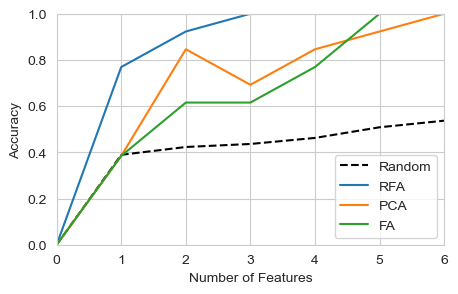

In [311]:
# Plot the results
f, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(x='n_features', y='Random', data=df_feats, label='Random', c='black', linestyle='--')
sns.lineplot(x='n_features', y='RFA', data=df_feats, label='RFA')
sns.lineplot(x='n_features', y='PCA', data=df_feats, label='PCA')
sns.lineplot(x='n_features', y='FA', data=df_feats, label='FA')
plt.ylim(0.0,1)
plt.xlim(0,6)
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [312]:
# SVD and PCA are the best feature extraction methods
(df_feats.PCA - df_feats.SVD).sum()

0.0

In [313]:
# 7 most important features ofr each model.
df_imp = pd.DataFrame()
for name, method in f_extraction.items():
    df_imp = pd.concat([df_imp, pd.DataFrame({name: method['features']})], axis=1)
best_features = best_features + [np.nan]* (len(df_imp)-len(best_features))
df_imp = pd.concat([df_imp, pd.DataFrame({'RFA': best_features})], axis=1)
df_imp

,PCA,FA,SVD,RFA
0,221864_at,220997_s_at,221864_at,205174_s_at
1,208734_x_at,211494_s_at,208734_x_at,201215_at
2,200965_s_at,221942_s_at,201745_at,1053_at
3,201745_at,221910_at,200965_s_at,NaN
4,212827_at,207639_at,212827_at,NaN
5,218764_at,219148_at,218764_at,NaN
6,210088_x_at,216452_at,200733_s_at,NaN
